# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

import phik
import stringcase

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

## Подготовка данных

### Загрузка

In [3]:
data = pd.read_csv('autos.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные загрузились нормально. 

Типы данных определились корректно кроме дат в DateCrawled, DateCreated и LastSeen.

Есть пропуски.

Имена колонок можно переделать из Camel в snake

In [6]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    data[col] = pd.to_datetime(data[col])

In [7]:
data.columns = map(stringcase.snakecase, data.columns)

### Предобработка

In [8]:
# Пропуски
tmp = pd.DataFrame()
tmp['count'] = data.isna().sum()
tmp['%'] = (100 * tmp['count'] / data.shape[0]).round()
display(tmp)
del tmp

,count,%
date_crawled,0,0.0
price,0,0.0
vehicle_type,37490,11.0
registration_year,0,0.0
gearbox,19833,6.0
power,0,0.0
model,19705,6.0
kilometer,0,0.0
registration_month,0,0.0
fuel_type,32895,9.0


Есть много пропусков:

- тип кузова
- коробка передач
- модель
- тип топлива
- был ли ремонт

Можно предположить, что отсутствие записи в последней колонке равнозначно тому, что машина не была в ремонте.
Остальные угадывать совершенно бессмысленно - заполним заглушкой.

In [9]:
data['repaired'] = data['repaired'].fillna('no')

for col in ['vehicle_type', 'gearbox', 'model', 'fuel_type']:
    data[col] = data[col].fillna('unknown')

In [10]:
# Полные дубликаты 
display(data.duplicated().sum())

5

Есть полные дубликаты. Таких совпадений не бывает (цена - год - пробег). Удалим

In [11]:
data.drop_duplicates(keep=False, inplace=True)
data.reset_index(drop=True, inplace=True)

### Исследовательский анализ

In [12]:
num_columns = [
    'price',
    'power',
    'kilometer'   
]

cat_columns = [
    'vehicle_type',
    'registration_year',
    'gearbox',
    'model',
    'registration_month',
    'fuel_type',
    'brand',
    'repaired',
    'number_of_pictures'
]

# не характеристика машины
ext_columns = [
    'date_crawled', 
    'date_created', 
    'last_seen',
    'postal_code'
]

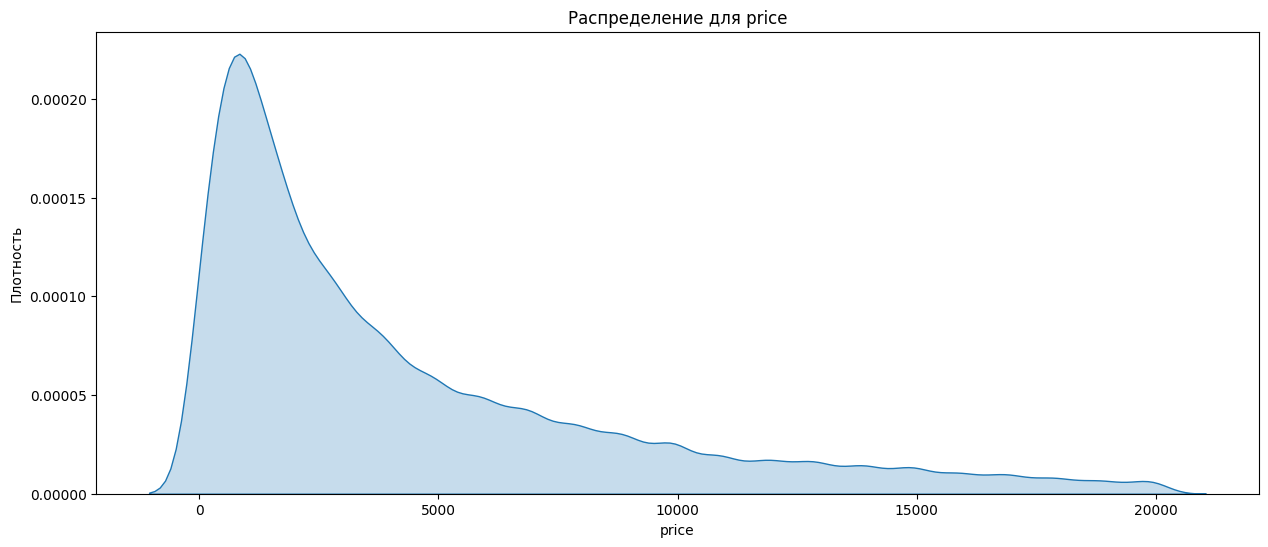

count    354359.000000
mean       4416.654441
std        4514.160867
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

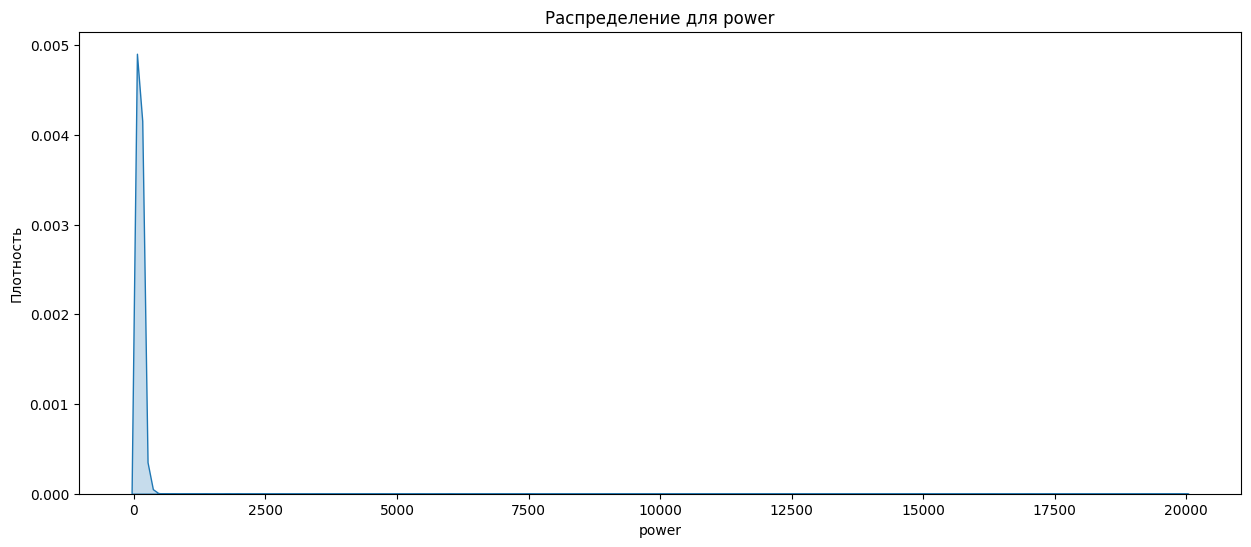

count    354359.000000
mean        110.093109
std         189.852775
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

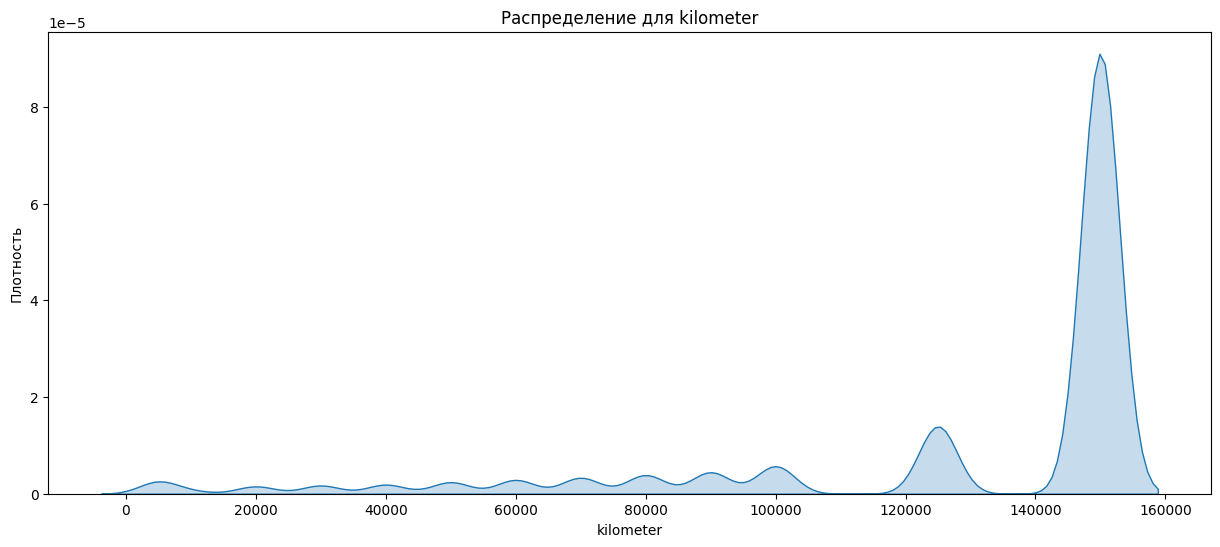

count    354359.000000
mean     128211.573574
std       37904.932377
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [13]:
for col in num_columns:
    
    plt.figure(figsize=(15,6))
    
    sns.kdeplot(
        data[col], 
        fill=True
    )
    
    plt.title(f'Распределение для {col}')
    plt.xlabel(col)
    plt.ylabel('Плотность')
    
    plt.show()
    
    display(data[col].describe())

Для пробега явных аномалий/выбросов нет, есть нулевые цены. 

Для мощности есть - 0 л.с. не бывает, а больше 500 весьма редко.

Нулевые цены, пожалуй, надо убрать - обучать модель на авто с нулевой ценой странно.

Нулевую / большую мощность можно оставить и убрать только в том случае, если дойдёт до линейной регрессии

In [14]:
#data[data.power == 0]
tmp = data[data.power == 0]
display(tmp.head())
print(tmp.shape)
del tmp

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,unknown,0,ka,5000,0,petrol,ford,no,2016-03-11,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,unknown,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,unknown,2016,unknown,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,unknown,1990,unknown,0,corsa,150000,1,petrol,opel,no,2016-03-26,0,56412,2016-03-27 17:43:34


(40225, 16)


In [15]:
#data[data.power > 500]
tmp = data[data.power > 500]
display(tmp.head())
print(tmp.shape)
del tmp

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,unknown,1799,vectra,150000,1,petrol,opel,yes,2016-03-21,0,1723,2016-04-04 04:49:06
3746,2016-03-21 14:48:31,0,unknown,2017,manual,750,unknown,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,no,2016-03-29,0,33154,2016-04-06 05:44:36


(459, 16)


In [16]:
data = data[data.price != 0]

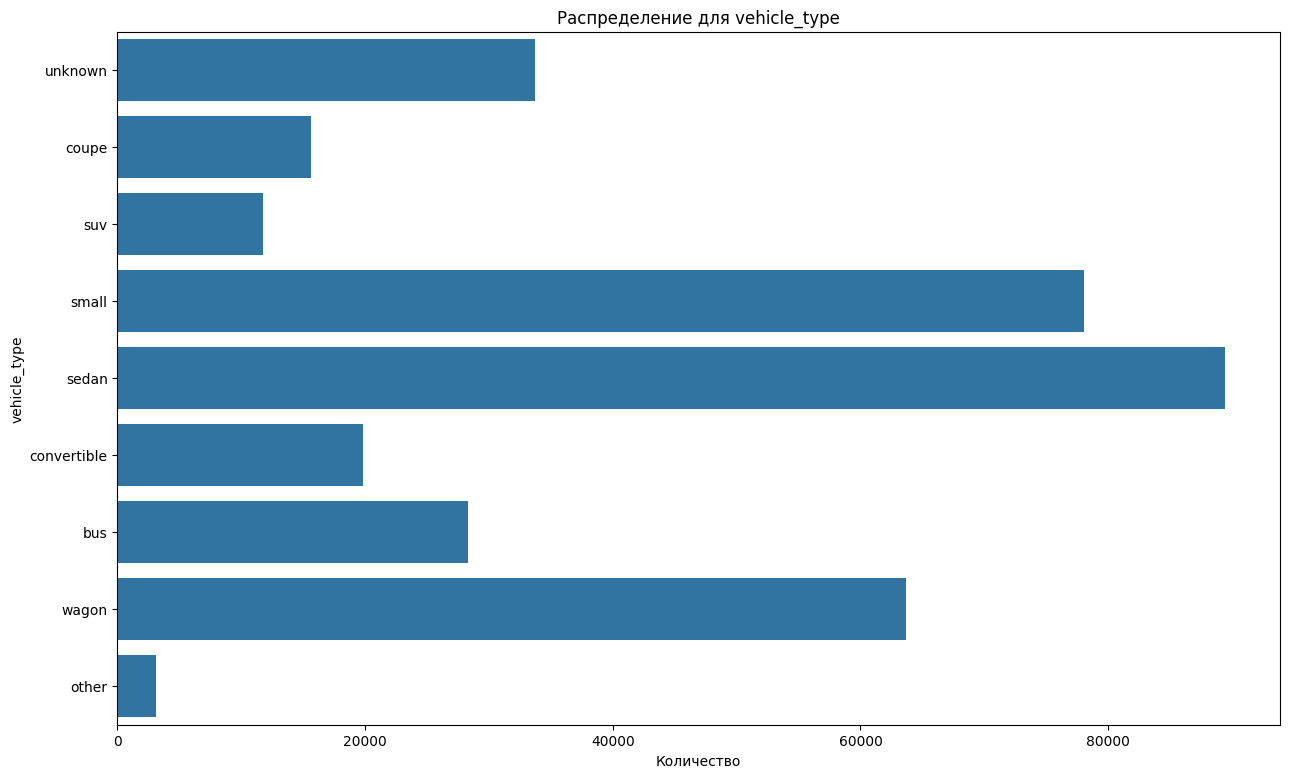

count     343587
unique         9
top        sedan
freq       89403
Name: vehicle_type, dtype: object

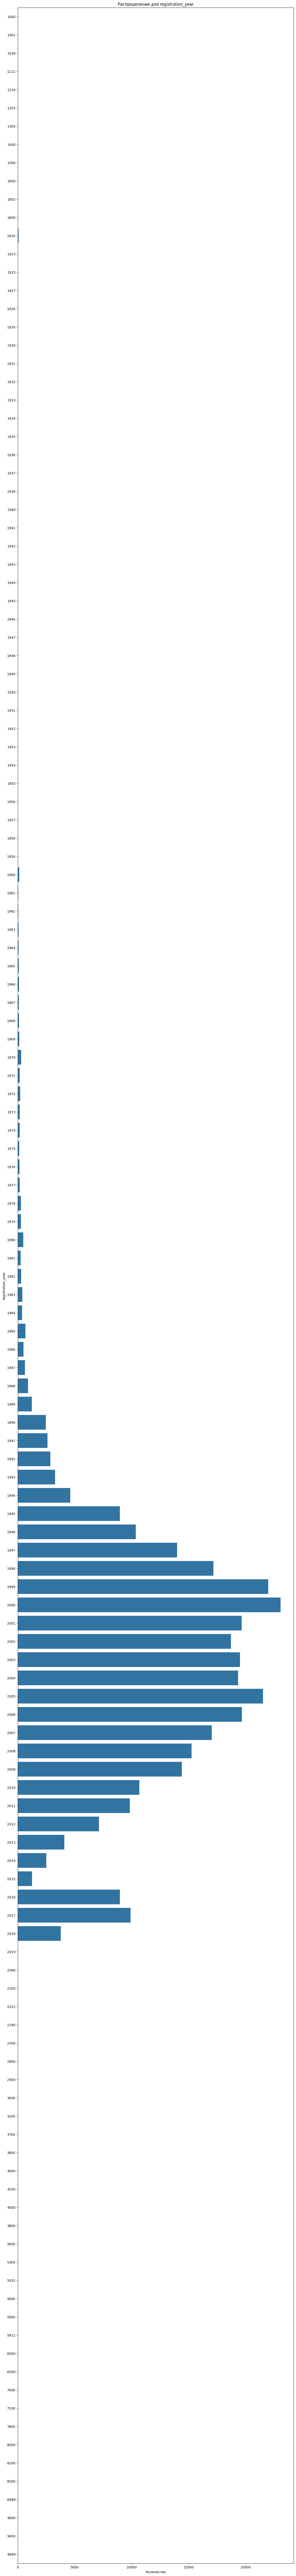

count    343587.000000
mean       2004.089840
std          78.414364
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

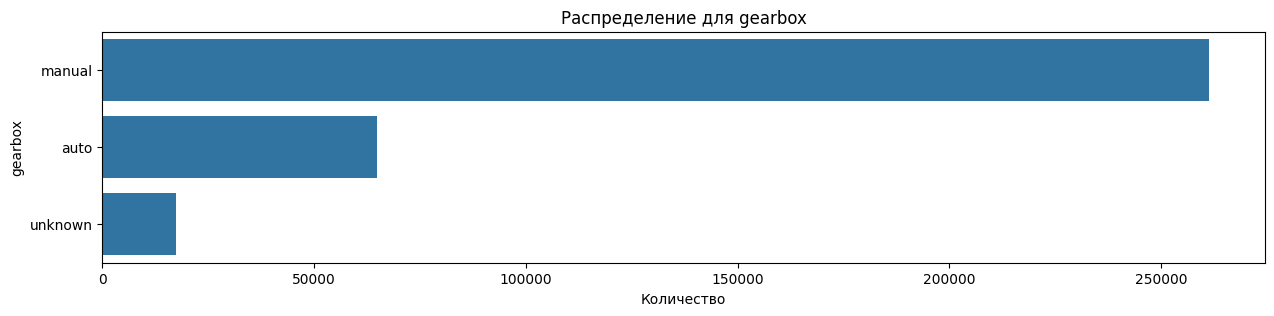

count     343587
unique         3
top       manual
freq      261367
Name: gearbox, dtype: object

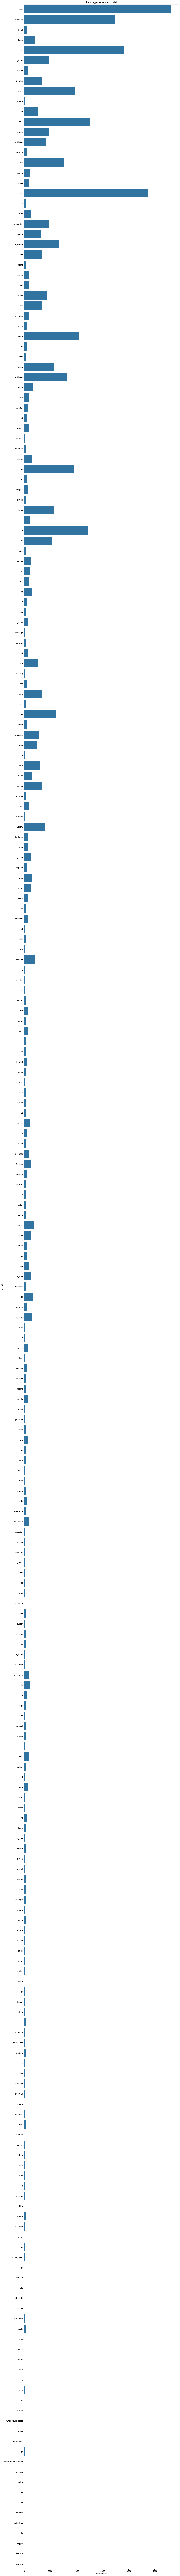

count     343587
unique       251
top         golf
freq       28246
Name: model, dtype: object

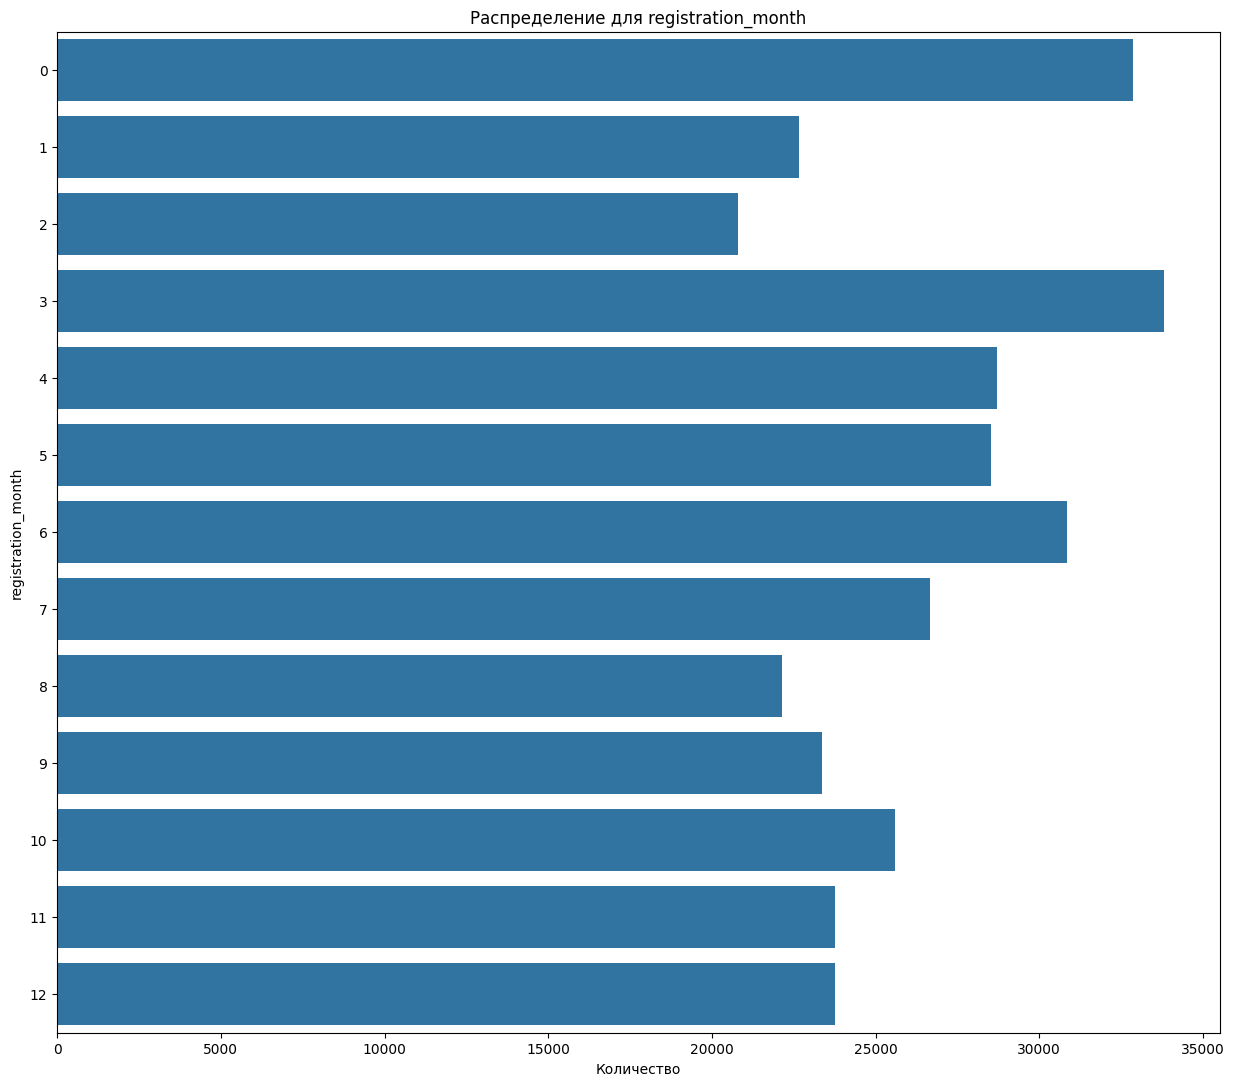

count    343587.000000
mean          5.777884
std           3.698211
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

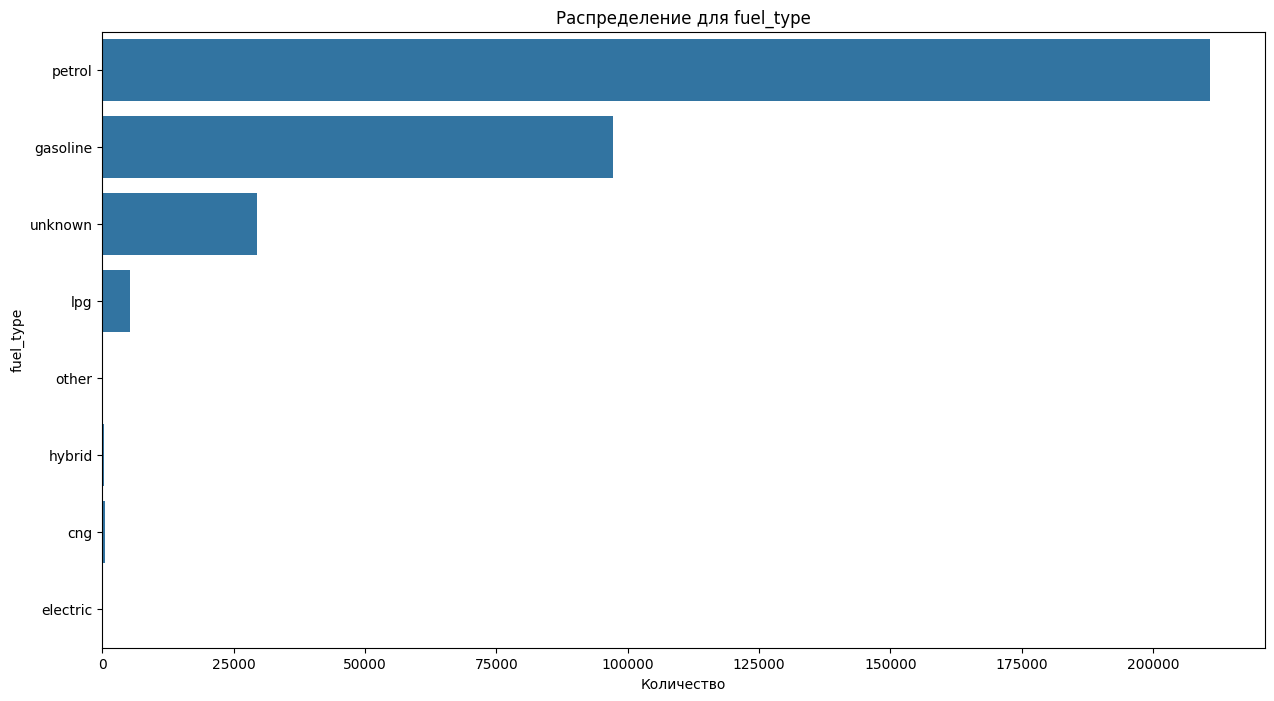

count     343587
unique         8
top       petrol
freq      210759
Name: fuel_type, dtype: object

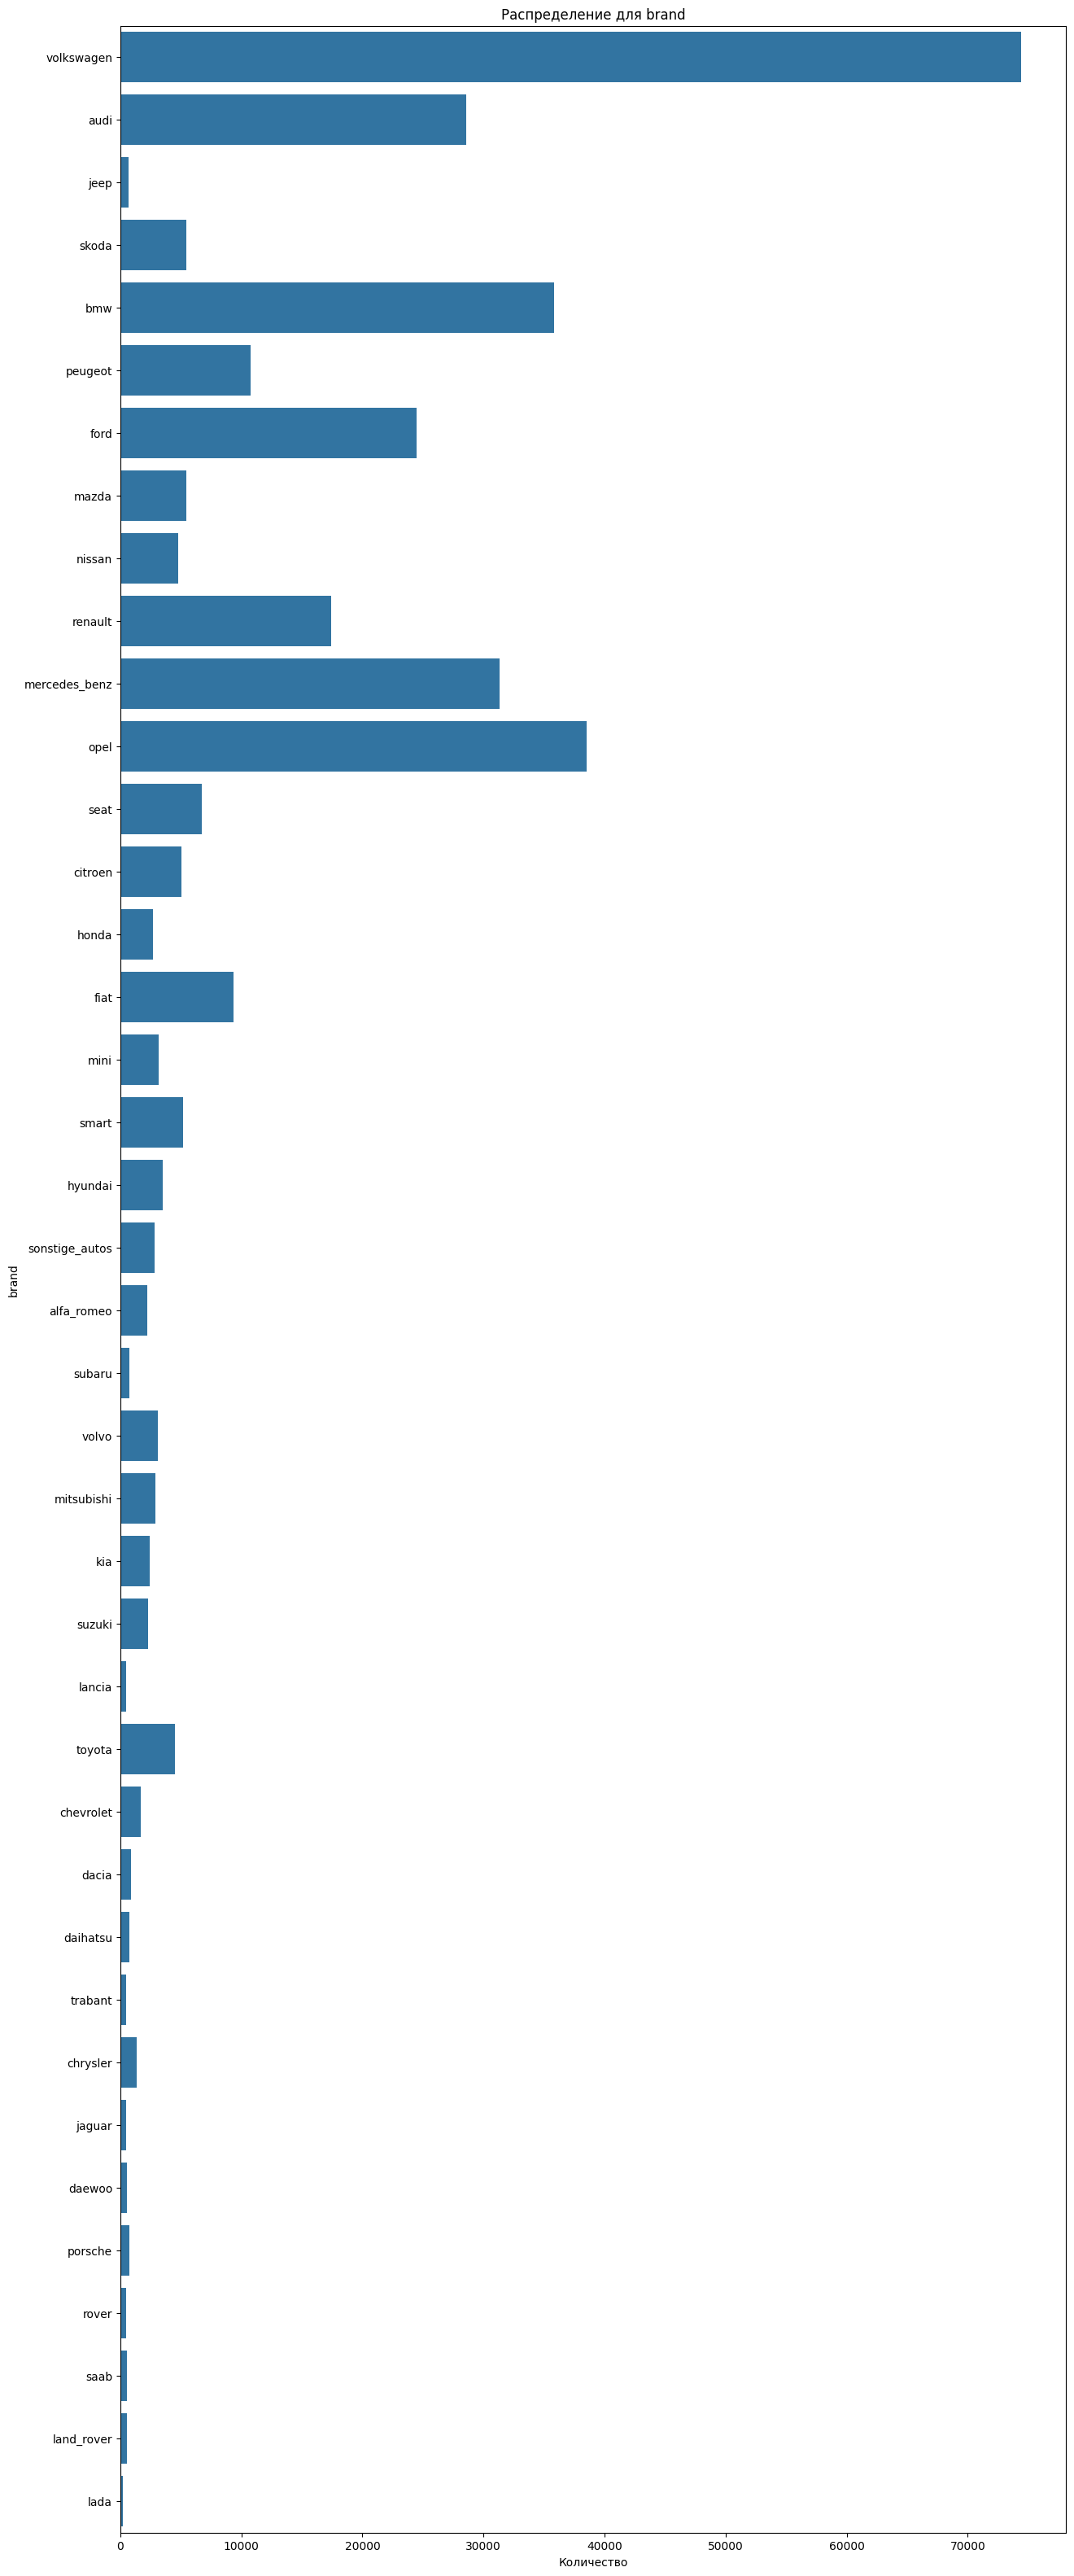

count         343587
unique            40
top       volkswagen
freq           74411
Name: brand, dtype: object

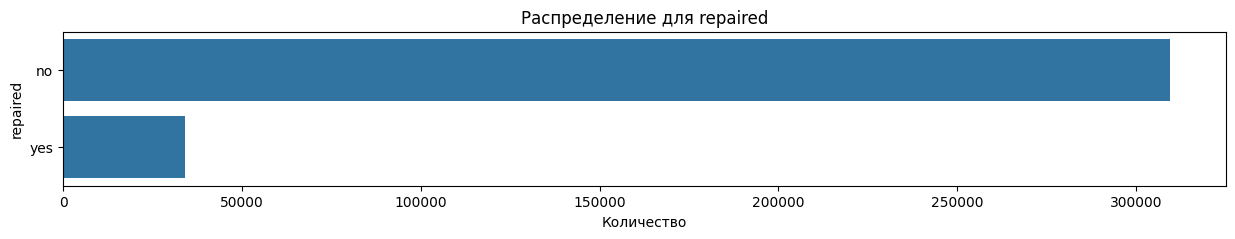

count     343587
unique         2
top           no
freq      309540
Name: repaired, dtype: object

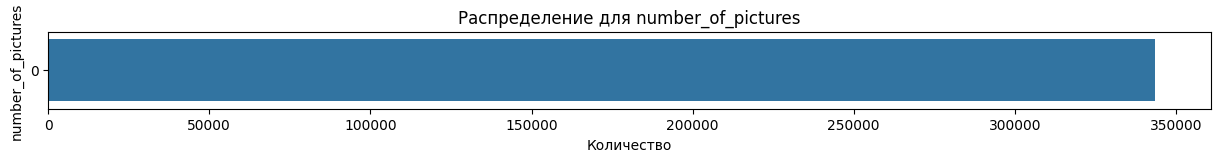

count    343587.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

In [17]:
# осторожно - очень длинные графики
for col in cat_columns:
    
    h = data[col].nunique()
    
    plt.figure(figsize=(15, h))
    
    sns.countplot(
        y=data[col]
    )
    
    plt.title(f'Распределение для {col}')
    plt.ylabel(col)
    plt.xlabel('Количество')
    
    plt.show()
    
    display(data[col].describe())

По порядку:
- vehicle_type - ОК
- registration_year - явные аномалии (< 1900 и > 2016)
- gearbox - ОК
- model - ОК
- registration_month - ОК
- fuel_type - ОК
- brand - ОК
- repaired - ОК
- number_of_pictures - все нулевые. Похоже, что-то сломалось, можно не брать для обучения

In [18]:
data.date_created.max()

Timestamp('2016-04-07 00:00:00')

In [19]:
data.date_crawled.max()

Timestamp('2016-04-07 14:36:58')

In [20]:
data = data[(data.registration_year >= 1990) & (data.registration_year <= 2016)]

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320884 entries, 0 to 354358
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        320884 non-null  datetime64[ns]
 1   price               320884 non-null  int64         
 2   vehicle_type        320884 non-null  object        
 3   registration_year   320884 non-null  int64         
 4   gearbox             320884 non-null  object        
 5   power               320884 non-null  int64         
 6   model               320884 non-null  object        
 7   kilometer           320884 non-null  int64         
 8   registration_month  320884 non-null  int64         
 9   fuel_type           320884 non-null  object        
 10  brand               320884 non-null  object        
 11  repaired            320884 non-null  object        
 12  date_created        320884 non-null  datetime64[ns]
 13  number_of_pictures  320884 non-nul

In [22]:
data.describe()

,date_crawled,price,registration_year,power,kilometer,registration_month,date_created,number_of_pictures,postal_code,last_seen
count,320884,320884.000000,320884.000000,320884.000000,320884.000000,320884.000000,320884,320884.0,320884.000000,320884
mean,2016-03-21 12:34:31.866914304,4590.911273,2003.223112,112.583825,128785.838496,5.846468,2016-03-20 18:45:55.567744,0.0,50780.238566,2016-03-30 00:36:06.429124096
min,2016-03-05 14:06:22,1.000000,1990.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 10:47:53,1200.000000,1999.000000,73.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30519.000000,2016-03-23 05:20:47.750000128
50%,2016-03-21 17:40:54,2900.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49610.000000,2016-04-03 16:46:25
75%,2016-03-29 14:45:11.249999872,6599.000000,2007.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71282.000000,2016-04-06 10:16:18.249999872
max,2016-04-07 14:36:58,20000.000000,2016.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4536.179383,5.605593,181.989812,36926.848285,3.676378,NaN,0.0,25722.706689,NaN


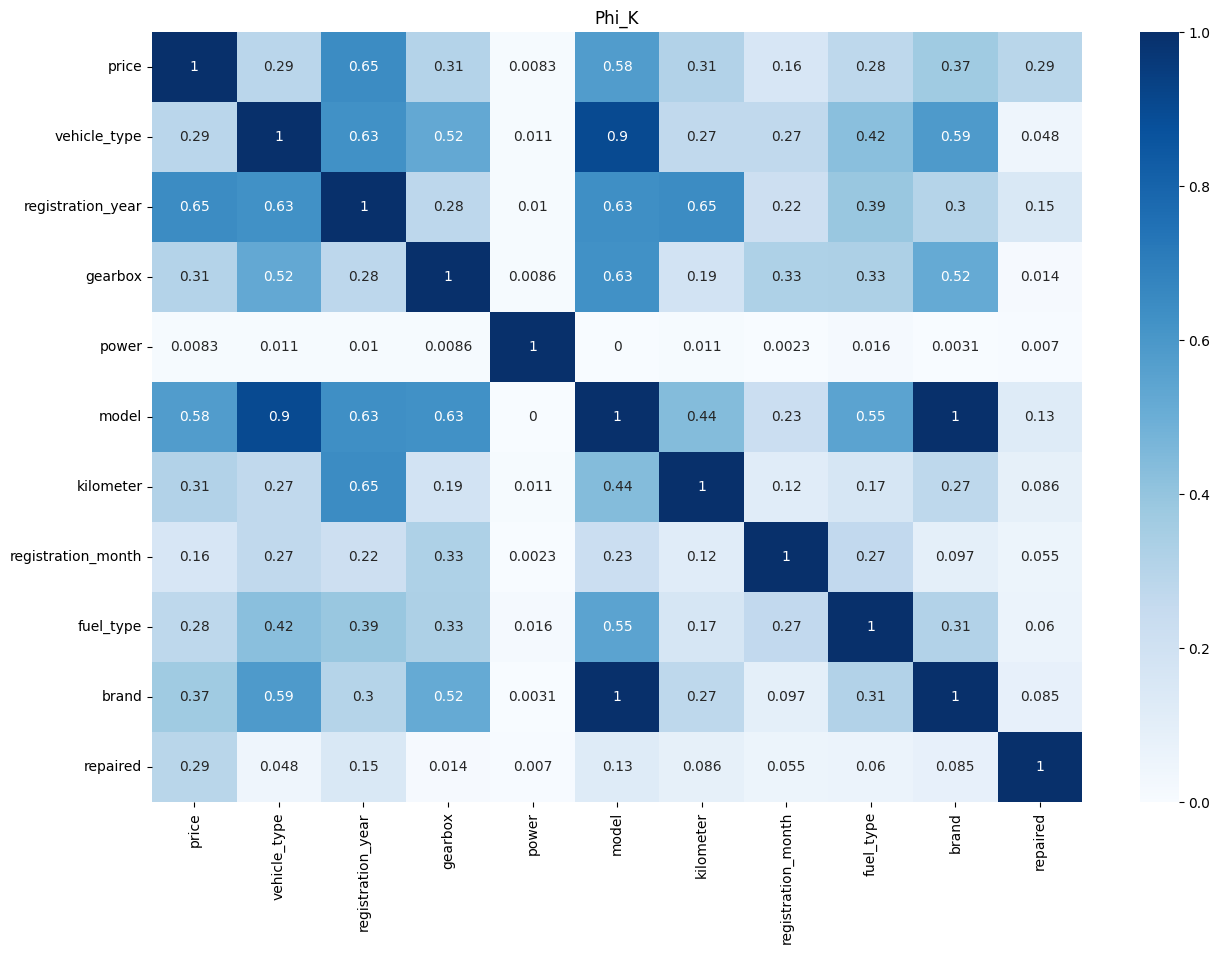

In [23]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    data.drop(
        ext_columns + ['number_of_pictures'], 
        axis=1
    ).phik_matrix(
        interval_cols=num_columns
    ), 
    cmap='Blues',
    annot=True
)
plt.title(f'Phi_K')
plt.show()

Есть ожидаемая полная корреляция марка-модель. Если не использовать линейные модели, то можно оставить.

Сильная корреляция модель-кузов - видимо, наиболее часто среди объявлений одна модель встречается в каком-то самом популярном исполнении.

### Итог
Данные готовы для обучения на них моделей, но только не чувствительных к выбросам и мультиколлинеарности.

## Обучение моделей
Возьмём DecisionTreeRegressor в качестве базовой модели и сравним с LGBMRegressor

In [24]:
X = data.drop(
        ext_columns + ['number_of_pictures', 'price'], 
        axis=1
)

y = data['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

In [25]:
print(
    X.shape,
    '->',
    X_train.shape,
    '+',
    X_test.shape
)

(320884, 10) -> (256707, 10) + (64177, 10)


In [26]:
print(
    y.shape,
    '->',
    y_train.shape,
    '+',
    y_test.shape
)

(320884,) -> (256707,) + (64177,)


In [27]:
ohe_columns = [
    'vehicle_type', 
    'gearbox',
    'model',
    'fuel_type', 
    'brand', 
    'repaired'
]

### DecisionTreeRegressor

In [28]:
preprocessor_1 = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns)
    ], 
    remainder='passthrough'
)

In [29]:
pipe_1 = Pipeline(
    [
        ('preprocessor', preprocessor_1),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [30]:
param_1 = {
    'model__max_depth': [5, 7],
    'model__min_samples_split': [2, 4]
}

In [31]:
grid_1 = GridSearchCV(
    pipe_1, 
    param_1, 
    cv=5,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [32]:
%%time
grid_1.fit(X_train, y_train)

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: user 3.46 s, sys: 513 ms, total: 3.97 s
Wall time: 20.2 s


/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired'])])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 7],
                         'model__min_samples_split': [2, 4]},
             scoring='neg_root_mean_squared_error')

In [33]:
rmse = - grid_1.best_score_
print(f'RMSE = {rmse:.1f}')

RMSE = 2124.9


In [34]:
%%time
_ = grid_1.predict(X_train)

CPU times: user 304 ms, sys: 387 ms, total: 691 ms
Wall time: 690 ms


### LGBMRegressor

In [35]:
pipe_2 = Pipeline(
    [
        ('preprocessor', preprocessor_1),
        ('model', LGBMRegressor(random_state=RANDOM_STATE))
    ]
)

In [36]:
param_2 = {
    'model__max_depth': [5, 7],
    'model__n_estimators': [50, 100]
}

In [37]:
grid_2 = GridSearchCV(
    pipe_2, 
    param_2, 
    cv=5,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [38]:
%%time
grid_2.fit(X_train, y_train)

/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted wit

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 256707, number of used features: 293
[LightGBM] [Info] Start training from score 4590.505604
CPU times: user 3.55 s, sys: 504 ms, total: 4.05 s
Wall time: 8min 5s


/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired'])])),
                                       ('model',
                                        LGBMRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 7],
                         'model__n_estimators': [50, 100]},
             scoring='neg_root_mean_squared_error')

In [39]:
rmse = - grid_2.best_score_
print(f'RMSE = {rmse:.1f}')

RMSE = 1659.0


In [40]:
%%time
_ = grid_2.predict(X_train)

CPU times: user 1.14 s, sys: 363 ms, total: 1.51 s
Wall time: 736 ms


/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Итог
Обучены 2 модели: базовая DecisionTreeRegressor и LGBMRegressor с бустингом под капотом. 
Реализован подбор гиперпараметров.

## Анализ моделей

Модель с бустингом обучается примерно за то же время, что и базовая, но даёт значительно лучшее качество даже при не очень тщательном подборе гиперпараметров.

Есть простор для улучшения - убрать аномалии в мощности и годе, отмаштабировать числовые и попробовать другие модели (LinearRegression, SVR). Также можно поискать лучшие гиперпараметры в вариантах с бустингом.

Что из этого нужно заказчику из описания задачи не ясно - требуется и быстрая, и точная модель. 

In [43]:
# старые цифры
time = pd.DataFrame()

time['Модель'] = ['DecisionTreeRegressor', 'LGBMRegressor']
time['RMSE на обучающей'] = [2125, 1659]
time['Обучение, с'] = [20, 485]
time['Предсказание, с'] = [0.7, 0.7]

time

,Модель,RMSE на обучающей,"Обучение, с","Предсказание, с"
0,DecisionTreeRegressor,2125,20,0.7
1,LGBMRegressor,1659,485,0.7


По точности и скорости обучения LGBMRegressor вдвое превосходит DecisionTreeRegressor, но по вренени предсказания прогрывает почти вдвое.
Итого 2:1 в пользу LGBMRegressor.
Проверим её на тестовой.

In [42]:
rmse = - grid_2.score(X_test, y_test)
print(f'RMSE = {rmse:.1f}')

RMSE = 1667.0


/home/sergey/.jupyter/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Точность на тестовой практически идентична точности на обучающей - модель в порядке.